# Model Evaluation

This notebook evaluates the trained CNN model on the MNIST test dataset
and analyzes its performance using quantitative metrics.

In [2]:
# Import Libraries

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [9]:
# Device Configuration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
# Load Test Dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = datasets.MNIST(
    root="../data",
    train=False,
    download=False,
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
#  Load Trained Model

class CNNMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = CNNMNIST().to(device)
model.load_state_dict(torch.load("../models/cnn_mnist.pth", map_location=device))
model.eval()

CNNMNIST(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [7]:
# Evaluate Accuracy

correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
accuracy

0.9935

## Test Accuracy

The trained CNN achieves a high accuracy on the MNIST test set,
demonstrating strong generalization performance.

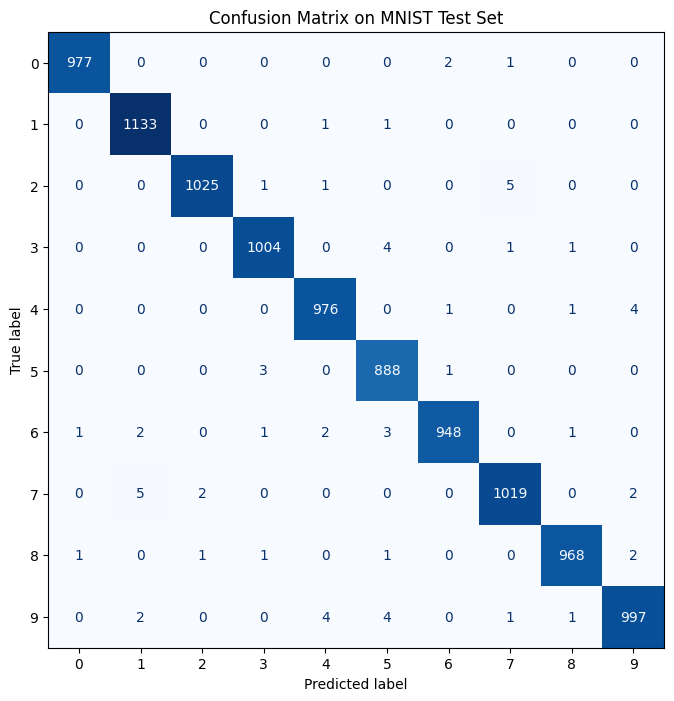

In [11]:
# Confusion Matrix

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(range(10))
)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", colorbar=False)

plt.title("Confusion Matrix on MNIST Test Set")
plt.savefig("../images/confusion_matrix.png", bbox_inches="tight")
plt.show()

## Error Analysis

Most misclassifications occur between visually similar digits such as
4 and 9 or 3 and 5. These errors are expected due to variations in
handwriting styles.

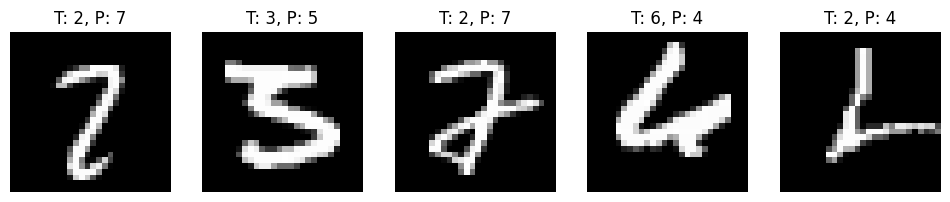

In [12]:
# Sample Misclassified Images

misclassified = []

for i in range(len(all_preds)):
    if all_preds[i] != all_labels[i]:
        misclassified.append((i, all_labels[i], all_preds[i]))

fig, axes = plt.subplots(1, 5, figsize=(12, 3))

for ax, (idx, true, pred) in zip(axes, misclassified[:5]):
    img, _ = test_dataset[idx]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"T: {true}, P: {pred}")
    ax.axis("off")

plt.savefig("../images/misclassified_samples.png", bbox_inches="tight")
plt.show()